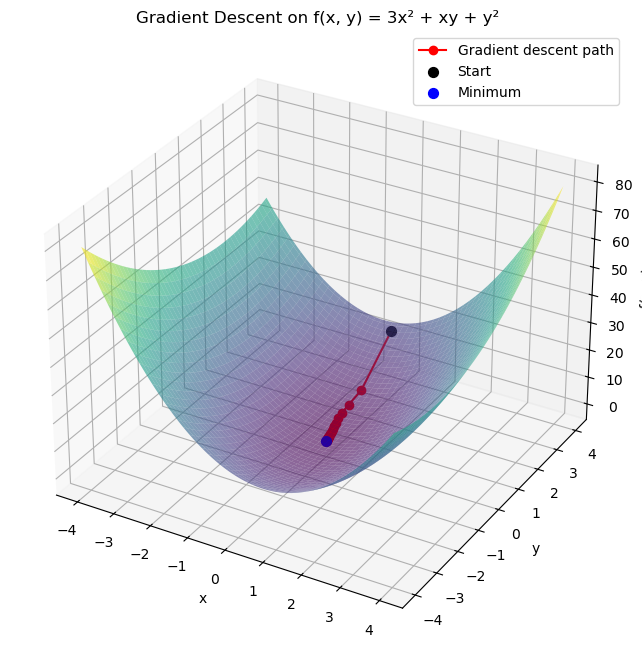

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Funkcja celu
def f(x, y):
    return 3 * x**2 + x*y + y**2

# Parametry optymalizacji
lr = 0.1
epochs = 50

# Startowe punkty
x = tf.Variable(2.0)
y = tf.Variable(3.0)

# Optymalizator
optimizer = tf.keras.optimizers.SGD(learning_rate=lr)

# Historia do wizualizacji
x_list, y_list, f_list = [], [], []

# Pętla optymalizacji
for epoch in range(epochs):
    with tf.GradientTape() as tape:
        z = f(x, y)
    grads = tape.gradient(z, [x, y])
    optimizer.apply_gradients(zip(grads, [x, y]))

    # Zapisz dane do wizualizacji
    x_list.append(x.numpy())
    y_list.append(y.numpy())
    f_list.append(z.numpy())

# Siatka do wizualizacji funkcji
x_grid = np.linspace(-4, 4, 100)
y_grid = np.linspace(-4, 4, 100)
X, Y = np.meshgrid(x_grid, y_grid)
Z = f(X, Y)

# Wizualizacja 3D
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, cmap='viridis', alpha=0.6)

# Trajektoria optymalizacji
ax.plot(x_list, y_list, f_list, color='r', marker='o', label='Gradient descent path')
ax.scatter(x_list[0], y_list[0], f_list[0], color='black', s=50, label='Start')
ax.scatter(x_list[-1], y_list[-1], f_list[-1], color='blue', s=50, label='Minimum')

# Opis osi
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('f(x, y)')
ax.set_title('Gradient Descent on f(x, y) = 3x² + xy + y²')
ax.legend()
plt.show()

In [4]:
import numpy as np

# ---------------------------
# Funkcje aktywacji i ich pochodne
# ---------------------------
def relu(Z):
    return np.maximum(0, Z)

def relu_backward(dA, Z):
    dZ = dA.copy()
    dZ[Z <= 0] = 0
    return dZ

def tanh(Z):
    return np.tanh(Z)

def tanh_backward(dA, Z):
    return dA * (1 - np.tanh(Z)**2)

# ---------------------------
# Architektura sieci
# ---------------------------
nn_architecture = [
    {"input_dim": 2, "output_dim": 2, "activation": "relu"},
    {"input_dim": 2, "output_dim": 1, "activation": "tanh"},
]

# ---------------------------
# Inicjalizacja wag
# ---------------------------
def init_layers(architecture, seed=42):
    np.random.seed(seed)
    parameters = {}
    for idx, layer in enumerate(architecture):
        layer_idx = idx + 1
        input_dim = layer["input_dim"]
        output_dim = layer["output_dim"]
        parameters["W" + str(layer_idx)] = np.random.randn(output_dim, input_dim) * 0.1
        parameters["b" + str(layer_idx)] = np.zeros((output_dim, 1))
    return parameters

# ---------------------------
# Propagacja w przód
# ---------------------------
def single_forward(A_prev, W, b, activation):
    Z = np.dot(W, A_prev) + b
    if activation == "relu":
        A = relu(Z)
    elif activation == "tanh":
        A = tanh(Z)
    else:
        raise Exception("Activation not supported")
    return A, Z

def full_forward(X, parameters, architecture):
    memory = {}
    A = X
    for idx, layer in enumerate(architecture):
        layer_idx = idx + 1
        W = parameters["W" + str(layer_idx)]
        b = parameters["b" + str(layer_idx)]
        activation = layer["activation"]

        A_prev = A
        A, Z = single_forward(A_prev, W, b, activation)

        memory["A" + str(idx)] = A_prev
        memory["Z" + str(layer_idx)] = Z
    memory["A" + str(len(architecture))] = A
    return A, memory

# ---------------------------
# Funkcja kosztu (MSE)
# ---------------------------
def compute_cost(Y_hat, Y):
    m = Y.shape[1]
    return np.sum((Y_hat - Y)**2) / (2 * m)

# ---------------------------
# Propagacja wsteczna
# ---------------------------
def single_backward(dA, W, Z, A_prev, activation):
    m = A_prev.shape[1]
    if activation == "relu":
        dZ = relu_backward(dA, Z)
    elif activation == "tanh":
        dZ = tanh_backward(dA, Z)
    else:
        raise Exception("Activation not supported")
    dW = (1 / m) * np.dot(dZ, A_prev.T)
    db = (1 / m) * np.sum(dZ, axis=1, keepdims=True)
    dA_prev = np.dot(W.T, dZ)
    return dA_prev, dW, db

def full_backward(Y_hat, Y, memory, parameters, architecture):
    grads = {}
    m = Y.shape[1]
    dA_prev = Y_hat - Y

    for idx_prev, layer in reversed(list(enumerate(architecture))):
        layer_idx = idx_prev + 1
        activation = layer["activation"]
        A_prev = memory["A" + str(idx_prev)]
        Z = memory["Z" + str(layer_idx)]
        W = parameters["W" + str(layer_idx)]

        dA_prev, dW, db = single_backward(dA_prev, W, Z, A_prev, activation)

        grads["dW" + str(layer_idx)] = dW
        grads["db" + str(layer_idx)] = db

    return grads

# ---------------------------
# Przykładowe dane wejściowe
# ---------------------------
X = np.array([[0.5, -0.3], [0.1, 0.8]]).T  # shape (2, 2)
Y = np.array([[1, 0]])  # shape (1, 2)

# ---------------------------
# Uruchomienie procesu
# ---------------------------
params = init_layers(nn_architecture)
Y_hat, memory = full_forward(X, params, nn_architecture)
cost = compute_cost(Y_hat, Y)
grads = full_backward(Y_hat, Y, memory, params, nn_architecture)

# ---------------------------
# Wyniki
# ---------------------------
print("Koszt:", cost)
for i in range(1, len(nn_architecture) + 1):
    print(f"dW{i} =", grads["dW" + str(i)])
    print(f"db{i} =", grads["db" + str(i)])


Koszt: 0.25034170254432614
dW1 = [[ 5.85780444e-03 -3.51468267e-03]
 [ 3.51719632e-06  2.81375706e-05]]
db1 = [[1.17156089e-02]
 [3.51719632e-05]]
dW2 = [[-0.01450165 -0.00019276]]
db2 = [[-0.5018413]]
